In [1]:
import win32com.client
import pyttsx3;
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input

In [2]:
#Class that actually executes the commands to retrieve email information
class Command():
    def __init__(self):
        outlook = win32com.client.Dispatch('outlook.application')
        self.mapi = outlook.GetNamespace("MAPI")
        
    def readLastInboxMessage(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Body
    
    def readLastInboxSubject(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Subject

    def getAttachmentofLastEmail(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Attachments  
    
    def execute(self, commandType):
        if commandType == 1:
            return self.readLastInboxMessage()
        elif commandType == 2:
            return self.readLastInboxSubject()
        else:
            return None

In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary = True) #Loads in pretrained word2vec model

In [5]:
model.most_similar("file")#Test to check what most similar words are

[('files', 0.7133816480636597),
 ('filing', 0.647048830986023),
 ('filed', 0.5737501382827759),
 ('refile', 0.5691325664520264),
 ('Rod_Aydelotte_photo', 0.5590430498123169),
 ('File', 0.5576274991035461),
 ('fi_le', 0.551184892654419),
 ('Image_###K_GIF', 0.5502156615257263),
 ('Filing', 0.5267105102539062),
 ('Image_##K_GIF', 0.5109704732894897)]

In [46]:
#Gets and reshapes all the data from the dataset to be in the correct format for the NN
colnames = ["input","label"]
ds = pd.read_csv('synthetic_training_data.csv', usecols = colnames)
with open("stoplist.txt", "r") as F:
    stoplist = F.read()
    clean = []
for i in range(0, len(ds["input"])):
    clean.append([word for word in ds["input"][i].split() if word not in stoplist])

x_train = np.array([])
zero = np.zeros(shape = (1,300))

for i in range(0, len(ds["input"])):
    sentence = clean[i]
    vec = np.array([])
    for j in range(0,len(sentence)):
        word = model[sentence[j]]
        vec = np.append(vec, word)
    vec = vec.reshape(j+1,300)
    for k in range(j,19):
        vec = np.append(vec, zero)
    vec = np.array(vec)
    vec = vec.reshape(20,300)
    x_train = np.append(x_train, vec)
x_train = x_train.reshape(len(ds["input"]),20, 300)
print(x_train.shape)

(1120, 20, 300)


In [47]:
num_classes = 3
temp = ds["label"]
y_train = []
for i in temp:
    current = [0] * num_classes
    current[i-1] = 1
    y_train.append(current)

y_train = np.array(y_train, dtype = int)
print(y_train.shape)

(1120, 3)


In [48]:
#This can be ignored - Was being used to test the validation set.
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
x_training, x_valid, y_training, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)
print(x_training.shape)

(784, 20, 300)


In [74]:
#Creating the Neural NEtwork
nnmodel = keras.Sequential()
nnmodel.add(keras.layers.InputLayer(input_shape = (20, 300)))
nnmodel.add(keras.layers.Flatten())
nnmodel.add(keras.layers.Dropout(0.1))
nnmodel.add(keras.layers.Dense(units = 2000, activation = "relu"))
nnmodel.add(keras.layers.Dropout(0.1))
nnmodel.add(keras.layers.Dense(units = 1600, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 100, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 100, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 20, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = num_classes, activation = "softmax"))

optim = tf.keras.optimizers.Adam(learning_rate = 0.00001)

nnmodel.compile(optim, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
nnmodel.save_weights('model.h5')
history = nnmodel.fit(x_train, y_train, epochs=100, batch_size = 64)

Epoch 1/100
18/18 [==============================] - 1s 55ms/step - loss: 1.0842 - accuracy: 0.5455
Epoch 2/100
18/18 [==============================] - 1s 54ms/step - loss: 1.0426 - accuracy: 0.7812
Epoch 3/100
18/18 [==============================] - 1s 54ms/step - loss: 0.9861 - accuracy: 0.8536
Epoch 4/100
18/18 [==============================] - 1s 54ms/step - loss: 0.9150 - accuracy: 0.8759
Epoch 5/100
18/18 [==============================] - 1s 54ms/step - loss: 0.8323 - accuracy: 0.9107
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 0.7390 - accuracy: 0.9357
Epoch 7/100
18/18 [==============================] - 1s 54ms/step - loss: 0.6421 - accuracy: 0.9571
Epoch 8/100
18/18 [==============================] - 1s 53ms/step - loss: 0.5457 - accuracy: 0.9688
Epoch 9/100
18/18 [==============================] - 1s 54ms/step - loss: 0.4569 - accuracy: 0.9804
Epoch 10/100
18/18 [==============================] - 1s 53ms/step - loss: 0.3798 - accuracy: 0.9812

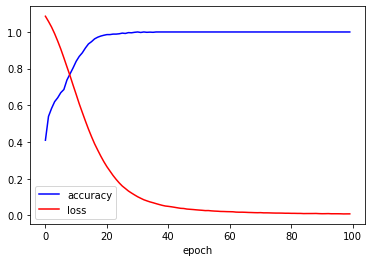

In [50]:
#All Loss-Accuracy Graphs
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['loss'], color = 'r')
plt.xlabel('epoch')
plt.legend(['accuracy','loss'])
plt.show()

In [51]:
#nnmodel.evaluate(x=x_valid, y=y_valid) 

11/11 [==============================] - 0s 8ms/step - loss: 0.0044 - accuracy: 1.0000


[0.0044215028174221516, 1.0]

In [59]:
#Gets the test set into the correct format
colnames = ["input","label"]
ds = pd.read_csv('synthetic_testing_data.csv', usecols = colnames)
#ds = pd.read_csv('synthetic_testing_data.csv', usecols = colnames)
with open("stoplist.txt", "r") as F:
    stoplist = F.read()
    clean = []
for i in range(0, len(ds["input"])):
    clean.append([word for word in ds["input"][i].split() if word not in stoplist])

x_test = np.array([])
zero = np.zeros(shape = (1,300))

for i in range(0, len(ds["input"])):
    sentence = clean[i]
    vec = np.array([])
    for j in range(0,len(sentence)):
        word = model[sentence[j]]
        vec = np.append(vec, word)
    vec = vec.reshape(j+1,300)
    for k in range(j,19):
        vec = np.append(vec, zero)
    vec = np.array(vec)
    vec = vec.reshape(20,300)
    x_test = np.append(x_test, vec)
x_test = x_test.reshape(len(ds["input"]),20, 300)
print(x_test.shape)

(1600, 20, 300)


In [60]:
num_classes = 3
temp = ds["label"]
y_test = []
for i in temp:
    current = [0] * num_classes
    current[i-1] = 1
    y_test.append(current)

y_test = np.array(y_test, dtype = int)
print(y_test.shape)

(1600, 3)


In [61]:
#Evaluates the model against the test set 
nnmodel.evaluate(x=x_test, y=y_test)

50/50 [==============================] - 0s 10ms/step - loss: 0.9258 - accuracy: 0.7206


[0.9257575273513794, 0.7206249833106995]

In [ ]:
#ignore this - used for generated results and graphs
for i in range(3,10):
    nnmodel.load_weights('model.h5')
    lr = 1 * pow(10,-i)
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    nnmodel.compile(optim, loss='categorical_crossentropy', metrics=['accuracy'])
    history = nnmodel.fit(x_train, y_train, epochs=250, batch_size = 128)
    plt.plot(lr, float(nnmodel.evaluate(x=x_test, y=y_test)[1]), 'bo')
plt.xlabel('Learning Rate')
plt.xscale("log")
plt.ylabel('accuracy')
plt.plot()
plt.show()

In [53]:
#an in depth look at the model's class predictions in the testing set
ar = nnmodel.predict(x=x_test)
excelnumber = 2
for i in ar:
    print(excelnumber, ": ",i.tolist().index(max(i)) + 1)
    excelnumber +=1
    

2 :  1
3 :  1
4 :  1
5 :  1
6 :  1
7 :  1
8 :  1
9 :  1
10 :  1
11 :  1
12 :  1
13 :  1
14 :  1
15 :  1
16 :  1
17 :  1
18 :  2
19 :  2
20 :  1
21 :  1
22 :  2
23 :  3
24 :  3
25 :  2
26 :  3
27 :  2
28 :  2
29 :  2
30 :  2
31 :  2
32 :  3
33 :  3
34 :  2
35 :  1
36 :  1
37 :  3
38 :  3
39 :  3
40 :  2
41 :  2
42 :  3
43 :  3
44 :  1
45 :  3
46 :  1


In [97]:
#Executes the email command using any given sentence. YOU MUST USE REAL WORDS
sentence = "return the topic"
clean = []
clean = [word for word in sentence.split() if word not in stoplist]
print(clean)
vec = np.array([])
for j in range(0,len(clean)):
    word = model[clean[j]]
    vec = np.append(vec, word)
vec = vec.reshape(j+1,300)
for k in range(j,19):
    vec = np.append(vec, zero)
vec = np.array(vec)
vec = vec.reshape(1, 20, 300)

ar = np.array(nnmodel.predict(vec))
print(ar)
classnum =  np.argmax(ar) + 1
print("Class Number: " , classnum)

emailController = Command()
print("Email Output: ")
emailController.execute(classnum)

['return', 'topic']
[[0.9146363  0.08253296 0.00283068]]
Class Number:  1
Email Output: 


' <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=340RO1NFOP1LW&T=O&U=https%3A%2F%2Fimages-eu.ssl-images-amazon.com%2Fimages%2FG%2F01%2Fnav%2Ftransp.gif&H=U4QVULOGULK3AB5YEICIRZGOQGEA&ref_=pe_27063361_487055811_opens> \r\n <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=2EZIWFJLF2IF4&T=C&U=https%3A%2F%2Fwww.amazon.co.uk%2Fref%3Dpe_27063361_487055811_TE_g_i&H=DZDLP9956CATGLSA9VJP6YAAFDKA&ref_=pe_27063361_487055811_TE_g_i> \t Your Orders <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=1KMD1S1SLE9AY&T=C&U=https%3A%2F%2Fwww.amazon.co.uk%2Fgp%2Fcss%2Fyour-orders-access%2Fref%3Dpe_27063361_487055811_TE_oh_tn&H=2G4AUARB2VHP4ZHPTCA67MT76FMA&ref_=pe_27063361_487055811_TE_oh_tn>  \t  |   \tYour Account <https://www.amazon.co.uk/gp/f.html?C=2X8R0PK3LTH